# Model 3: Scenario & Robustness Analysis

Building on Model 2's dynamic framework, this 
model introduces "what-if" scenarios to test the strategy's robustness against key uncertainties. 
It evaluates performance against risks like volatile resource prices and increased bidding 
competition. The analysis also incorporates major policy and  environmental variables by 
modelling the financial impact of a new, tech-specific carbon tax. Finally, it simulates weather-
driven revenue fluctuations for renewables by applying variable capacity factors (good vs. bad 
years) to the revenue streams.

##### Notebook Outline
1) Imports
2) Load Input Data
3) Scenario Parameters
4) Gurobi Model Setup
5) Results
6) Visualizations

#### Flow Chart of Optimisation Model

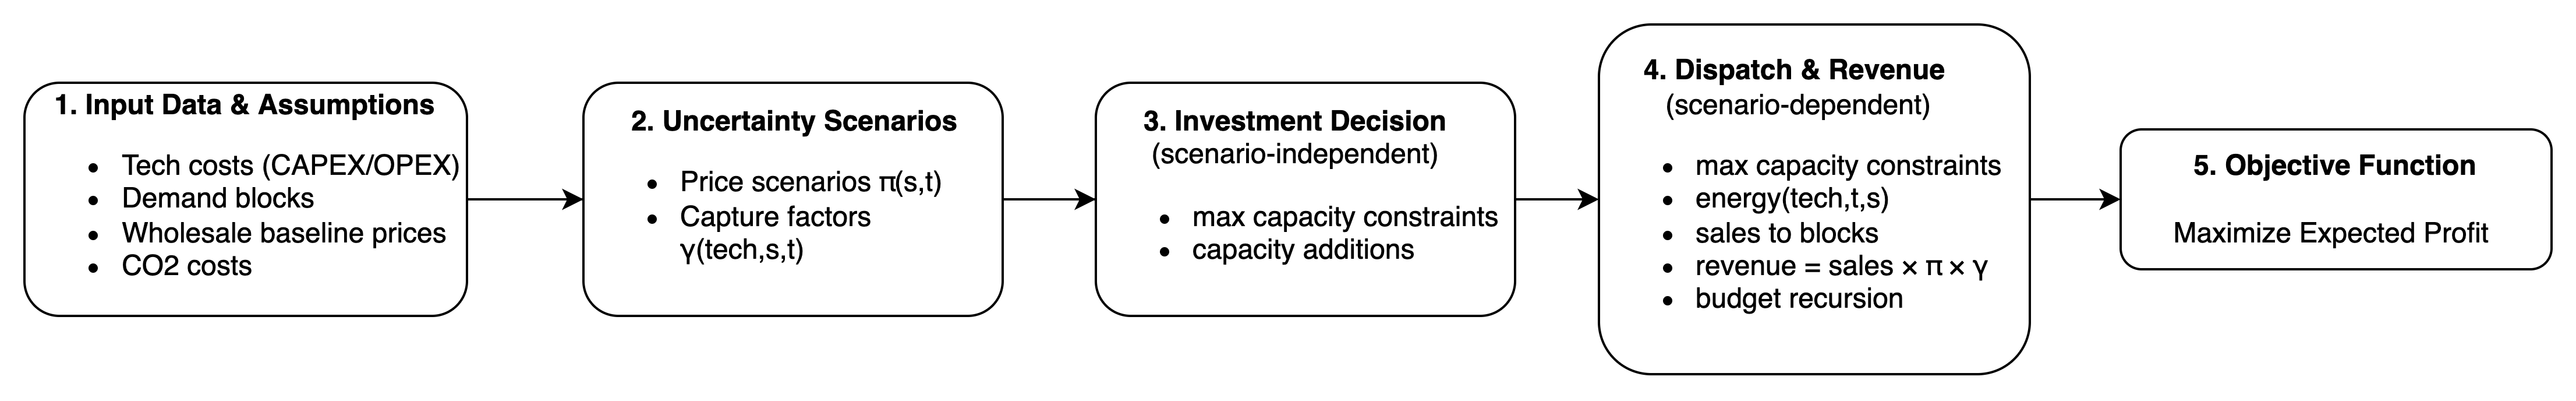
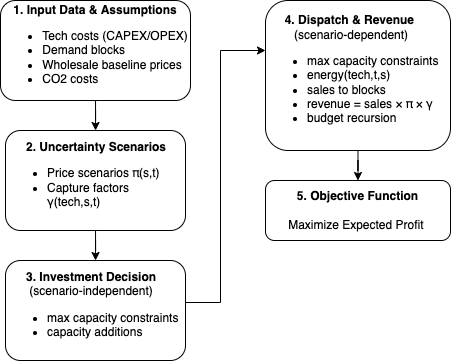

### Imports

In [1]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import seaborn as sns

### Load input data

In [2]:
import random

seed = 42

np.random.seed(seed)

random.seed(seed)

# Instruct Gurobi to use the same seed for any randomized routines (best-effort;
# model may be created later, so use gp.setParam which applies globally)
try:
    gp.setParam("Seed", seed)
except Exception:
    pass

print(f"Reproducibility seed set to {seed}")

Set parameter Username
Set parameter LicenseID to value 2625590
Academic license - for non-commercial use only - expires 2026-02-20
Set parameter Seed to value 42
Reproducibility seed set to 42


In [3]:
# technology data
data_path = Path("data") / "technology_data.json"

with data_path.open("r", encoding="utf-8") as f:
    technology_data = json.load(f)

TECHNOLOGY_UNITS = technology_data["TECHNOLOGY_UNITS"]  
TECHNOLOGY_DATA = technology_data["TECHNOLOGY_DATA"]

df_units = pd.DataFrame(list(TECHNOLOGY_UNITS.items()), columns=["Parameter", "Unit"])
df_tech = pd.DataFrame(TECHNOLOGY_DATA).reset_index().rename(columns={"index": "parameter"})
df = df_units.merge(df_tech, left_on="Parameter", right_on="parameter", how="right").drop(columns=["parameter"])
print("Technology Data:")
display(df)

# load electricity prices
num_periods_prices = 20
price_data_path = Path("data") / "electricity_prices.xlsx"
df_prices = pd.read_excel(price_data_path)[["Year", "Price"]].iloc[:num_periods_prices]
df_prices["Year"] = df_prices["Year"].astype(int)
df_prices["Price"] = df_prices["Price"].astype(float)

exchange_rate = 7.4 # DKK to EUR
df_prices["Price"] = df_prices["Price"]/exchange_rate
price_list = df_prices["Price"].tolist()

df_display = df_prices.T
df_display.columns = df_prices["Year"].tolist()
df_display = df_display.drop("Year")
print("Electricity Prices (EUR/MWh):")
display(df_display)

# load co2 intensity for technologies
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "CO2 intensity": 0
}
costs = costs.value.unstack().fillna(defaults)

co2_intensity = {
    "Diesel engine farm":         costs.at["gas", "CO2 intensity"]*1.2,
    "OCGT - Natural gas":         costs.at["gas", "CO2 intensity"],
    "Coal power plant":           costs.at["coal", "CO2 intensity"],
    "Nuclear power plant":        costs.at["nuclear", "CO2 intensity"],
    "Onshore wind":               costs.at["onwind", "CO2 intensity"],
    "Offshore wind (fixed)":      costs.at["offwind", "CO2 intensity"],
    "Utility-scale PV":           costs.at["solar-utility", "CO2 intensity"],
}

df_co2 = pd.DataFrame.from_dict(co2_intensity, orient="index", columns=["CO2 intensity (tCO2/MWh)"]).T
print("CO2 Intensity by Technology:")
display(df_co2)

net_capacity = pd.read_csv(Path("data") / "net_installed_capacity.csv")
# Drop the first (metadata) row, reset index, convert capacity columns to numeric and compute total (MW)
net_capacity = net_capacity.iloc[1:].reset_index(drop=True)

# Convert all columns except 'Year' to numeric (they are GW in the source)
num_cols = [c for c in net_capacity.columns if c != "Year"]
net_capacity[num_cols] = net_capacity[num_cols].apply(pd.to_numeric, errors="coerce")

# Sum capacities (assume values are in GW) and convert to MW
sum_capacity_gw = net_capacity[num_cols].sum().sum()
sum_capacity = sum_capacity_gw * 1e3  # MW

print("Net installed capacity (cleaned):")
display(net_capacity)
print(f"Total installed capacity in dataset: {sum_capacity:.2f} MW")

Technology Data:


,Parameter,Unit,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
0,nominal_investment_total,MEUR/MW_el,0.36,0.47,2.10,4.000,1.150,2.390,0.38
1,fixed_om_total,EUR/MW/year,8983.37,8236.12,34324.40,147700.000,16663.000,34000.000,9500.00
2,variable_om_total,EUR/MWh,6.38,4.79,3.21,20.000,0.000,0.000,0.00
3,elec_eff,fraction (0-1),0.35,0.41,0.52,0.360,0.410,0.520,0.16
4,technical_lifetime,years,25.00,25.00,25.00,60.000,30.000,30.000,35.00
5,construction_time,years,1.00,0.20,4.50,8.000,1.500,3.500,0.50
6,total_outage,fraction of time (0-1),0.01,0.01,0.00,0.001,0.023,0.025,NaN


Electricity Prices (EUR/MWh):


,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044
Price,90.598127,88.152135,83.576931,82.826762,80.538427,79.397276,74.590121,67.366515,64.427126,62.897569,58.468283,59.1168,59.890278,60.807289,61.886407,63.146206,64.605259,66.28214,68.195421,70.363677


CO2 Intensity by Technology:


,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
CO2 intensity (tCO2/MWh),0.2376,0.198,0.3361,0.0,0.0,0.0,0.0


Net installed capacity (cleaned):


,Year,Hydro Run-of-River,Biomass,Fossil hard coal,Fossil oil,Fossil gas,Other renewables,Waste,Wind offshore,Wind onshore,Solar AC
0,2025.0,0.01,1.75,3.02,0.96,1.57,0.14,0.38,2.65,4.86,3.73


Total installed capacity in dataset: 19070.00 MW


### Scenario Parameters

In [4]:
market_share = 0.10                               
hours_per_year = 8760

initial_budget = 150                              # MEUR
base_demand = market_share * 35_250_000           # MWh
demand_growth_rate = 0.02                         # yearly growth

carbon_price = 83  # EUR/tCO2, taken from https://tradingeconomics.com/commodity/carbon
carbon_increase = 5  # EUR/tCO2 per year

net_revenue_factor = 0.7 

num_scenarios = 100

# Maximum cumulative installed capacity per tech (MW)
max_capacity = {
    "Diesel engine farm":         market_share*sum_capacity*0.2,
    "OCGT - Natural gas":         market_share*sum_capacity*0.2,
    "Coal power plant":           market_share*sum_capacity*0.2,
    "Nuclear power plant":        market_share*sum_capacity*0.2,
    "Onshore wind":               market_share*sum_capacity*0.2,
    "Offshore wind (fixed)":      market_share*sum_capacity*0.2,
    "Utility-scale PV":           market_share*sum_capacity*0.2,
}

gamma_mean = {
    "Utility-scale PV":        0.85,
    "Onshore wind":            0.90,
    "Offshore wind (fixed)":   0.92,
    "OCGT - Natural gas":      1.05,
    "Diesel engine farm":      1.00,
    "Coal power plant":        1.00,
    "Nuclear power plant":     1.00,
}

# helper variables
baseline_prices = df_prices["Price"].tolist()   # EUR/MWh
num_periods = len(baseline_prices)
time_periods = list(range(num_periods))
scenarios = list(range(num_scenarios))
tech_names = list(TECHNOLOGY_DATA.keys())

### Uncertainty Scenario Generation

In [5]:
def generate_hub_price_scenarios(num_scenarios, baseline_prices):
    """
    Generate stochastic yearly hub price scenarios around a baseline price path.

    baseline_prices: list or array of yearly prices [EUR/MWh]
    returns: dict {scenario: [price_t for t in T]} in EUR/MWh
    """
    T = len(baseline_prices)
    scenarios = {}

    for s in range(num_scenarios):
        shock = 0.0
        price_path = []

        for t in range(T):
            eps = np.random.normal(0, 0.15)   # 15% price volatility
            shock = 0.7 * shock + eps         # AR(1) persistence
            price = baseline_prices[t] * (1 + shock)

            # allow negative but prevent extreme outliers
            price = max(-20, min(price, 300))

            price_path.append(price)

        scenarios[s] = price_path

    return scenarios

def generate_capture_factor_scenarios(tech_names, gamma_mean, 
                                      num_scenarios, num_periods,
                                      gamma_sigma=0.05, rho_gamma=0.7):
    """
    Generate tech-specific capture factor scenarios.
    
    gamma_mean: dict {tech: mean capture rate}
    returns: dict gamma[(tech, s, t)]
    """
    gamma = {}

    for tech in tech_names:
        for s in range(num_scenarios):
            shock = 0.0
            for t in range(num_periods):
                eps = np.random.normal(0, gamma_sigma)
                shock = rho_gamma * shock + eps

                g = gamma_mean.get(tech, 1.0) * (1 + shock)
                g = max(0.5, min(1.3, g))  # keep realistic bounds

                gamma[(tech, s, t)] = g

    return gamma

In [6]:
# generate electricity price scenarios
hub_price_scenarios = generate_hub_price_scenarios(
    num_scenarios=num_scenarios,
    baseline_prices=baseline_prices
)

# check lengths
for s in scenarios:
    assert len(hub_price_scenarios[s]) == num_periods, "All scenarios must have same length"

# generate capture factor scenarios    
gamma = generate_capture_factor_scenarios(
    tech_names=tech_names,
    gamma_mean=gamma_mean,
    num_scenarios=num_scenarios,
    num_periods=num_periods,
    gamma_sigma=0.05,
    rho_gamma=0.7
)

#### Preprocessing - build parameter dictionaries

In [7]:
#  Technical & economic parameters 
capex = {tech: TECHNOLOGY_DATA[tech]['nominal_investment_total']
         for tech in tech_names}

elec_eff = {tech: TECHNOLOGY_DATA[tech]['elec_eff']
            for tech in tech_names}

vom_eur = {tech: TECHNOLOGY_DATA[tech]['variable_om_total']
           for tech in tech_names}

vom_meur = {tech: vom_eur[tech] / 1e6
            for tech in tech_names}

fixed_om_eur = {tech: TECHNOLOGY_DATA[tech]['fixed_om_total']
                for tech in tech_names}

fixed_om_meur = {tech: fixed_om_eur[tech] / 1e6
                 for tech in tech_names}

#  Demand curve 
demand = {
    t: base_demand * ((1 + demand_growth_rate) ** t)
    for t in time_periods
}

#  Prices 
carbon_price_eur_per_tco2 = {
    t: carbon_price + carbon_increase*t     # EUR/tCO2
    for t in time_periods
}

carbon_price_meur_per_tco2 = {
    t: carbon_price_eur_per_tco2[t] / 1e6   # MEUR/tCO2
    for t in time_periods
}

price_scenarios_meur = {
    s: [p / 1e6 for p in hub_price_scenarios[s]]
    for s in scenarios
}

blocks = [1, 2, 3]

pi_block = {}
for s in scenarios:
    for t in time_periods:
        p = price_scenarios_meur[s][t]
        pi_block[(s, t, 1)] = 1.00 * p
        pi_block[(s, t, 2)] = 0.85 * p
        pi_block[(s, t, 3)] = 0.60 * p

blocks = [1, 2, 3]

#  Block quantity caps (per year, deterministic) 
Q_block = {}
for t in time_periods:
    Q_block[(t, 1)] = 0.25 * demand[t]  # highest-value block
    Q_block[(t, 2)] = 0.35 * demand[t]  # mid block
    Q_block[(t, 3)] = 0.40 * demand[t]  # lowest block

### Gurobi Model Setup

#### Variables

In [8]:
model = gp.Model("Dynamic_Revenue_Maximization")

# Investment in new capacity [MW] in period t (here-and-now)
investment = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Investment"
)

# Available capacity [MW] in period t (accumulated, here and now)
capacity = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Capacity"
)

# Energy produced [MWh] by tech in period t, scenario s
energy = model.addVars(
    tech_names, time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Energy"
)

# Budget available in each period t, scenario s [MEUR]
budget = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Budget"
)

# Revenue in each period t, scenario s [MEUR]
revenue = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Revenue"
)

# Variable O&M cost in each period t, scenario s [MEUR]
op_cost = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="OperatingCost"
)

# Fixed O&M cost in each period t (same across scenarios) [MEUR]
fixed_om_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="FixedOMCost"
)

# CAPEX in each period t (same across scenarios) [MEUR]
capex_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="CapexCost"
)

# CO2 cost in each period t, scenario s [MEUR]
co2_cost = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="CO2Cost"
)

# Energy  sold [MWh] by tech in period t, block b, scenario s
sales = model.addVars(
    tech_names, time_periods, blocks, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Sales"
)

#### Model constraints

In [9]:
# capacity accumulation (scenario independent)
for tech in tech_names:
    # Initial capacity is whatever is invested at t=0
    model.addConstr(
        capacity[tech, 0] == investment[tech, 0],
        name=f"CapacityInit_{tech}"
    )
    for t in time_periods[1:]:
        model.addConstr(
            capacity[tech, t] ==
            capacity[tech, t-1] + investment[tech, t],
            name=f"CapacityAccum_{tech}_{t}"
        )

# capacity limits (here-and-now)
for tech in tech_names:
    if tech in max_capacity:
        for t in time_periods:
            model.addConstr(
                capacity[tech, t] <= max_capacity[tech],
                name=f"MaxCap_{tech}_{t}"
            )

# production limits
# energy <= capacity * efficiency * hours_per_year
for tech in tech_names:
    for t in time_periods:
        for s in scenarios:
            model.addConstr(
                energy[tech, t, s] <=
                capacity[tech, t] * elec_eff[tech] * hours_per_year,
                name=f"ProdCap_{tech}_{t}_s{s}"
            )

# cost definitions
for t in time_periods:

    # CAPEX (scenario independent)
    model.addConstr(
        capex_cost[t] == gp.quicksum(
            investment[tech, t] * capex[tech]
            for tech in tech_names
        ),
        name=f"CapexCostDef_{t}"
    )

    # FIXED O&M (scenario independent)
    model.addConstr(
        fixed_om_cost[t] == gp.quicksum(
            capacity[tech, t] * fixed_om_meur[tech]
            for tech in tech_names
        ),
        name=f"FixedOMDef_{t}"
    )

    for s in scenarios:

        # VARIABLE O&M
        model.addConstr(
            op_cost[t, s] == gp.quicksum(
                energy[tech, t, s] * vom_meur[tech]
                for tech in tech_names
            ),
            name=f"OpCostDef_{t}_s{s}"
        )

        # CO₂ COST
        model.addConstr(
            co2_cost[t, s] == gp.quicksum(
                energy[tech, t, s]
                * co2_intensity[tech]
                * carbon_price_meur_per_tco2[t]
                for tech in tech_names
            ),
            name=f"CO2CostDef_{t}_s{s}"
        )

# energy -> block sales allocation (per tech)
for tech in tech_names:
    for t in time_periods:
        for s in scenarios:
            model.addConstr(
                gp.quicksum(sales[tech, t, b, s] for b in blocks)
                == energy[tech, t, s],
                name=f"SalesAlloc_{tech}_{t}_s{s}"
            )


for t in time_periods:
    # block capacity limits (competition across techs)
    for b in blocks:
        for s in scenarios:
            model.addConstr(
                gp.quicksum(sales[tech, t, b, s] for tech in tech_names)
                <= Q_block[(t, b)],
                name=f"BlockCap_{t}_{b}_s{s}"
            )
        
    # revenue with capture factors       
    for s in scenarios:
        model.addConstr(
            revenue[t, s] == gp.quicksum(
                sales[tech, t, b, s]
                * pi_block[(s, t, b)]
                * gamma[(tech, s, t)]
                * net_revenue_factor
                for tech in tech_names
                for b in blocks
            ),
            name=f"RevenueDef_{t}_s{s}"
        )

# budget constraints (scenario dependent)
for s in scenarios:

    # Initial budget
    model.addConstr(
        budget[0, s] == initial_budget,
        name=f"BudgetInit_s{s}"
    )

    for t in time_periods:

        # Investment cannot exceed budget of scenario s at time t
        model.addConstr(
            capex_cost[t] <= budget[t, s],
            name=f"InvLimit_t{t}_s{s}"
        )

        # Budget cannot go negative
        model.addConstr(
            budget[t, s] >= 0,
            name=f"BudgetNonNeg_t{t}_s{s}"
        )

        # Budget recursion for all except last period
        if t < num_periods - 1:
            model.addConstr(
                budget[t+1, s] ==
                budget[t, s]
                - capex_cost[t]
                + revenue[t, s]
                - op_cost[t, s]
                - fixed_om_cost[t]
                - co2_cost[t, s],
                name=f"BudgetDyn_{t}_s{s}"
            )

#### Objective Function + optimize

In [10]:
num_scenarios = len(scenarios)

model.setObjective(
    (1 / num_scenarios) * gp.quicksum(
        revenue[t, s]
        - op_cost[t, s]
        - co2_cost[t, s]
        - fixed_om_cost[t]
        - capex_cost[t]
        for s in scenarios
        for t in time_periods
    ),
    GRB.MAXIMIZE
)

model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 25.0.0 25A362)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
Seed  42

Optimize a model with 46320 rows, 64320 columns and 208273 nonzeros
Model fingerprint: 0x8049b77e
Coefficient statistics:
  Matrix range     [3e-06, 5e+03]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+06]
Presolve removed 24532 rows and 21477 columns
Presolve time: 0.06s
Presolved: 21788 rows, 42843 columns, 142641 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 175
 AA' NZ     : 8.346e+04
 Factor NZ  : 3.862e+05 (roughly 30 MB of memory)
 Factor Ops : 1.673e+07 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         P

#### Results

Underlying Uncertainties

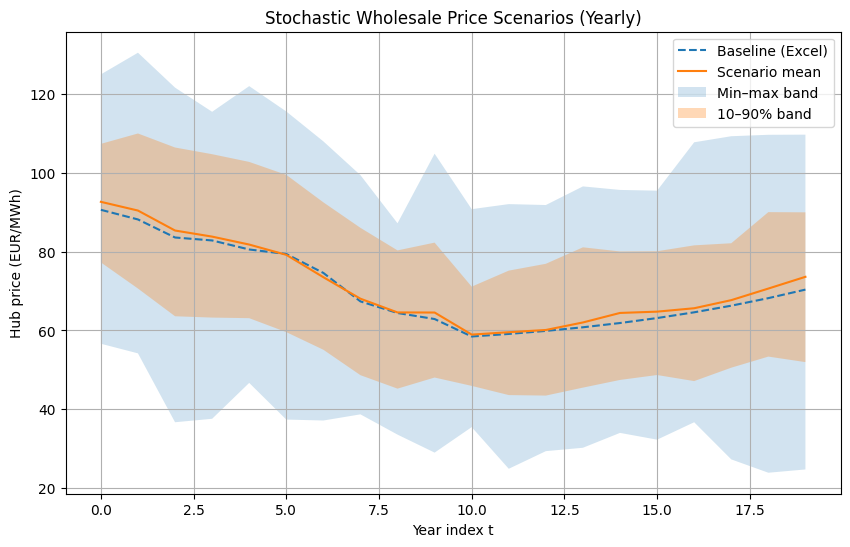

In [11]:
# wholesale prices

# Convert scenario dict to matrix [num_scenarios x num_periods]
price_matrix = np.array([
    hub_price_scenarios[s] for s in scenarios
])  # shape: (S, T)

mean_price = price_matrix.mean(axis=0)
min_price  = price_matrix.min(axis=0)
max_price  = price_matrix.max(axis=0)

# Optional: percentiles for less extreme bands
p10 = np.percentile(price_matrix, 10, axis=0)
p90 = np.percentile(price_matrix, 90, axis=0)

plt.figure(figsize=(10,6))

# Baseline from Excel
plt.plot(time_periods, baseline_prices, linestyle="--", label="Baseline (Excel)")

# Scenario mean
plt.plot(time_periods, mean_price, label="Scenario mean")

# Min–max band
plt.fill_between(time_periods, min_price, max_price, alpha=0.2, label="Min–max band")

# Optional: 10–90% band (less sensitive to outliers)
plt.fill_between(time_periods, p10, p90, alpha=0.3, label="10–90% band")

plt.xlabel("Year index t")
plt.ylabel("Hub price (EUR/MWh)")
plt.title("Stochastic Wholesale Price Scenarios (Yearly)")
plt.grid(True)
plt.legend()
plt.show()

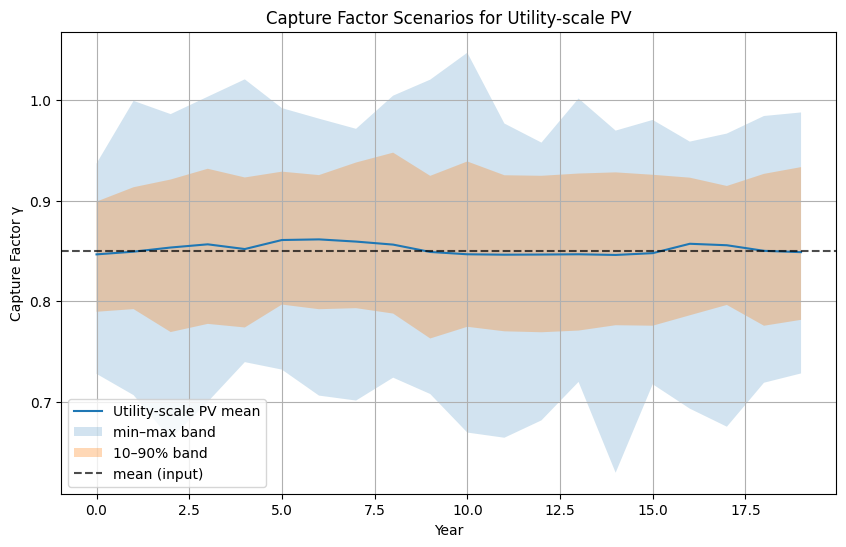

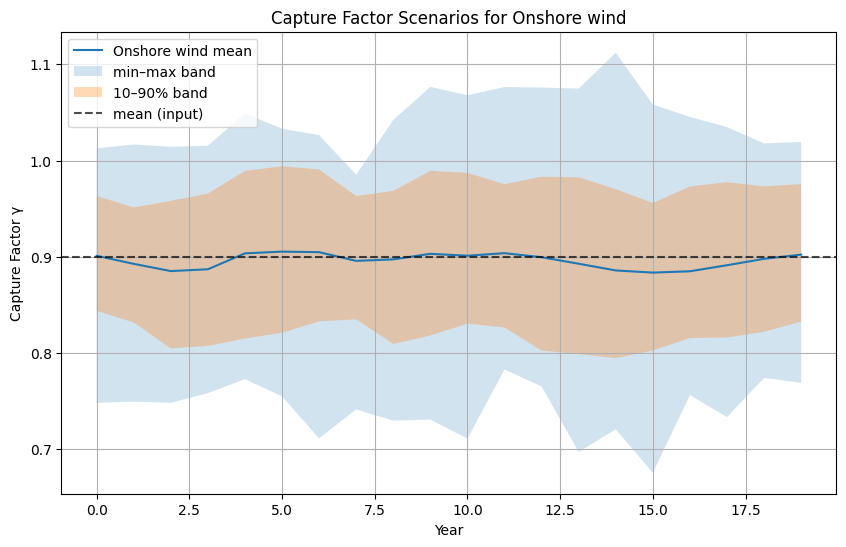

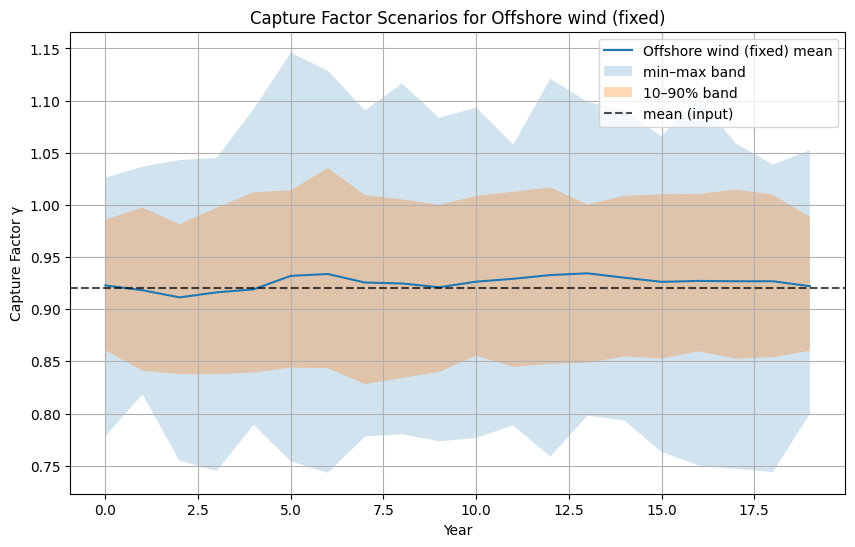

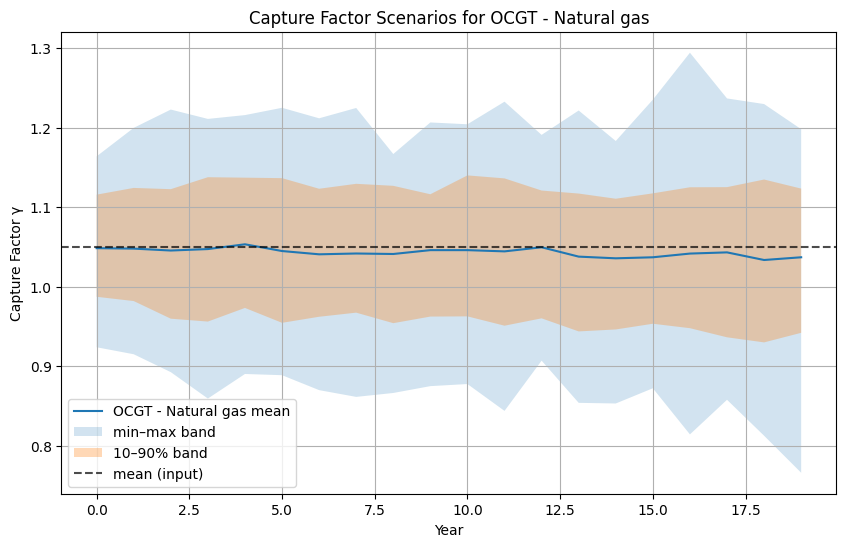

In [12]:
# capture factors

def build_gamma_matrix(tech):
    """
    Returns a matrix of shape [num_scenarios x num_periods]
    for the capture factor of a given technology.
    """
    mat = np.zeros((num_scenarios, num_periods))
    for s in scenarios:
        for t in time_periods:
            mat[s, t] = gamma[(tech, s, t)]
    return mat

def plot_gamma_for_tech(tech):
    gamma_mat = build_gamma_matrix(tech)

    mean_g = gamma_mat.mean(axis=0)
    p10    = np.percentile(gamma_mat, 10, axis=0)
    p90    = np.percentile(gamma_mat, 90, axis=0)
    min_g  = gamma_mat.min(axis=0)
    max_g  = gamma_mat.max(axis=0)

    plt.figure(figsize=(10,6))

    # Mean
    plt.plot(time_periods, mean_g, label=f"{tech} mean")

    # Min–max shading
    plt.fill_between(time_periods, min_g, max_g, alpha=0.2, label="min–max band")

    # 10–90% band
    plt.fill_between(time_periods, p10, p90, alpha=0.30, label="10–90% band")

    # Horizontal line at mean capture rate
    plt.axhline(gamma_mean.get(tech, 1.0), color='black', linestyle='--', alpha=0.7, label="mean (input)")

    plt.title(f"Capture Factor Scenarios for {tech}")
    plt.xlabel("Year")
    plt.ylabel("Capture Factor γ")
    plt.grid(True)
    plt.legend()
    plt.show()

for tech in ["Utility-scale PV", "Onshore wind", "Offshore wind (fixed)", "OCGT - Natural gas"]:
    plot_gamma_for_tech(tech)

Model Behavior Validation

Max violation of production limit: 0.000000 MWh
Max |Sales - Production| across all t,s: 0.000000 MWh
Max violation of block capacity constraints: 0.000000 MWh
Binding frequency: 1820/6000 (30.3%)
Block 1: binding in 91.0% of (t,s) combinations
Block 2: binding in 0.0% of (t,s) combinations
Block 3: binding in 0.0% of (t,s) combinations
Minimum budget over all t,s: 11.982206 MEUR
Maximum budget over all t,s: 846.91 MEUR
Mean budget over all t,s:    237.28 MEUR


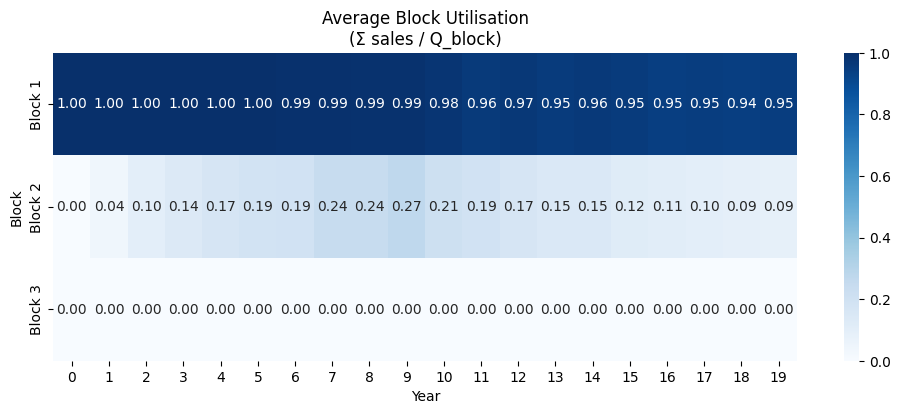

In [13]:
# Validate physical consitency: Energy ≤ Capacity · Efficiency · Hours

tol = 1e-6  

max_violation = 0.0

for tech in tech_names:
    for t in time_periods:
        cap_limit = capacity[tech, t].X * elec_eff[tech] * hours_per_year
        for s in scenarios:
            e = energy[tech, t, s].X
            violation = e - cap_limit
            if violation > max_violation:
                max_violation = violation

print(f"Max violation of production limit: {max_violation:.6f} MWh")

# Validate energy balance: Sales = Production

max_diff = 0.0

for s in scenarios:
    for t in time_periods:
        prod = sum(energy[tech, t, s].X for tech in tech_names)
        sold = sum(sales[tech, t, b, s].X for tech in tech_names for b in blocks)
        diff = sold - prod
        if abs(diff) > max_diff:
            max_diff = abs(diff)

print(f"Max |Sales - Production| across all t,s: {max_diff:.6f} MWh")

# block constraints and competition
tol = 1e-6
max_violation = 0.0
binding_count = 0
total_constraints = 0

for t in time_periods:
    for b in blocks:
        Q = Q_block[(t, b)]
        for s in scenarios:
            total_constraints += 1
            used = sum(sales[tech, t, b, s].X for tech in tech_names)
            violation = used - Q
            if violation > max_violation:
                max_violation = violation
            if abs(violation) < tol:  # almost equal -> binding
                binding_count += 1

print(f"Max violation of block capacity constraints: {max_violation:.6f} MWh")
print(f"Binding frequency: {binding_count}/{total_constraints} "
      f"({binding_count/total_constraints*100:.1f}%)")

binding_per_block = {b: 0 for b in blocks}
total_per_block   = {b: 0 for b in blocks}

for t in time_periods:
    for b in blocks:
        Q = Q_block[(t, b)]
        for s in scenarios:
            total_per_block[b] += 1
            used = sum(sales[tech, t, b, s].X for tech in tech_names)
            if abs(used - Q) < tol:
                binding_per_block[b] += 1

for b in blocks:
    freq = binding_per_block[b] / total_per_block[b] * 100
    print(f"Block {b}: binding in {freq:.1f}% of (t,s) combinations")

# budget feasibility
bud_vals = []

for s in scenarios:
    for t in time_periods:
        bud_vals.append(budget[t, s].X)

bud_vals = np.array(bud_vals)

print(f"Minimum budget over all t,s: {bud_vals.min():.6f} MEUR")
print(f"Maximum budget over all t,s: {bud_vals.max():.2f} MEUR")
print(f"Mean budget over all t,s:    {bud_vals.mean():.2f} MEUR")

util_block = pd.DataFrame(index=blocks, columns=time_periods, dtype=float)

for b in blocks:
    for t in time_periods:
        used = np.mean([
            sum(sales[tech, t, b, s].X for tech in tech_names)
            for s in scenarios
        ])
        util_block.loc[b, t] = used / Q_block[(t, b)]

plt.figure(figsize=(12,4))
sns.heatmap(util_block.astype(float), annot=True, fmt=".2f", cmap="Blues",
            yticklabels=[f"Block {b}" for b in blocks])
plt.title("Average Block Utilisation\n(Σ sales / Q_block)")
plt.xlabel("Year")
plt.ylabel("Block")
plt.show()


In [14]:
# gas margins

tech = "OCGT - Natural gas"

avg_margin_per_year = []
avg_prod_per_year   = []

for t in time_periods:
    # margins over blocks & scenarios
    margins_t = []
    prod_t    = []

    for s in scenarios:
        # total production (MWh) in year t, scenario s
        e_ts = energy[tech, t, s].X
        prod_t.append(e_ts)

        # compute weighted average margin over blocks (if produced)
        for b in blocks:
            unit_rev = pi_block[(s, t, b)] * gamma[(tech, s, t)] * net_revenue_factor
            unit_cost = vom_meur[tech] + co2_intensity[tech] * carbon_price_meur_per_tco2[t]
            margins_t.append((unit_rev - unit_cost) * 1e6)  # EUR/MWh

    avg_margin = np.mean(margins_t) if margins_t else 0.0
    avg_prod   = np.mean(prod_t)     # MWh

    avg_margin_per_year.append(avg_margin)
    avg_prod_per_year.append(avg_prod)

for t in time_periods:
    print(f"Year {t:2d}: avg margin = {avg_margin_per_year[t]:7.2f} EUR/MWh, "
          f"avg production = {avg_prod_per_year[t]/1e3:7.2f} GWh")

Year  0: avg margin =   34.30 EUR/MWh, avg production =  634.00 GWh
Year  1: avg margin =   31.92 EUR/MWh, avg production =  634.00 GWh
Year  2: avg margin =   27.78 EUR/MWh, avg production =  634.00 GWh
Year  3: avg margin =   25.93 EUR/MWh, avg production =  634.00 GWh
Year  4: avg margin =   24.09 EUR/MWh, avg production =  634.00 GWh
Year  5: avg margin =   21.05 EUR/MWh, avg production =  631.40 GWh
Year  6: avg margin =   16.54 EUR/MWh, avg production =  618.54 GWh
Year  7: avg margin =   12.35 EUR/MWh, avg production =  606.61 GWh
Year  8: avg margin =    9.27 EUR/MWh, avg production =  568.53 GWh
Year  9: avg margin =    8.41 EUR/MWh, avg production =  580.40 GWh
Year 10: avg margin =    4.14 EUR/MWh, avg production =  511.69 GWh
Year 11: avg margin =    3.40 EUR/MWh, avg production =  485.59 GWh
Year 12: avg margin =    2.91 EUR/MWh, avg production =  481.78 GWh
Year 13: avg margin =    2.70 EUR/MWh, avg production =  460.28 GWh
Year 14: avg margin =    3.08 EUR/MWh, avg produ

Expected Profit: 392.83 MEUR
Worst-Case Profit: 139.63 MEUR
Best-Case Profit: 737.76 MEUR
Volatility (Std Dev): 114.45 MEUR
Probability of Loss: 0.0%
CVaR (10% worst): 191.93 MEUR


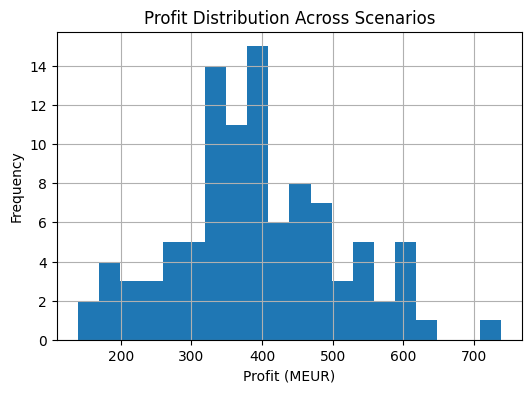

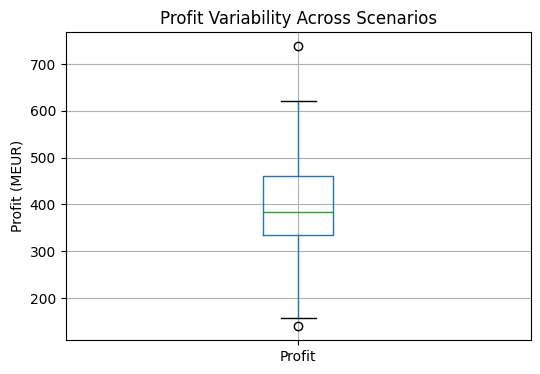

In [15]:
# profit distribution
scenario_profits = {}

for s in scenarios:
    total_profit = sum(
        revenue[t, s].X
        - op_cost[t, s].X
        - co2_cost[t, s].X
        - fixed_om_cost[t].X
        - capex_cost[t].X
        for t in time_periods
    )
    scenario_profits[s] = total_profit

df_profit = pd.DataFrame.from_dict(scenario_profits, orient='index', columns=['Profit'])

expected_profit = df_profit.Profit.mean()
worst_profit    = df_profit.Profit.min()
best_profit     = df_profit.Profit.max()
profit_vol      = df_profit.Profit.std()
loss_prob       = (df_profit.Profit < 0).mean() * 100
CVaR_10         = df_profit.Profit.nsmallest(int(0.1 * len(df_profit))).mean()

print(f"Expected Profit: {expected_profit:.2f} MEUR")
print(f"Worst-Case Profit: {worst_profit:.2f} MEUR")
print(f"Best-Case Profit: {best_profit:.2f} MEUR")
print(f"Volatility (Std Dev): {profit_vol:.2f} MEUR")
print(f"Probability of Loss: {loss_prob:.1f}%")
print(f"CVaR (10% worst): {CVaR_10:.2f} MEUR")

df_profit.Profit.plot(kind='hist', bins=20, figsize=(6,4), title="Profit Distribution Across Scenarios")
plt.xlabel("Profit (MEUR)")
plt.grid(True)
plt.show()

df_profit.boxplot(figsize=(6,4))
plt.title("Profit Variability Across Scenarios")
plt.ylabel("Profit (MEUR)")
plt.grid(True)
plt.show()


Investment Decisions & Capacity Trajectory

In [16]:
capacity_df = pd.DataFrame({
    t: {tech: capacity[tech, t].X for tech in tech_names}
    for t in time_periods
})

capacity_df.index.name = "Technology"
capacity_df.loc["Total"] = capacity_df.sum(axis=0)
capacity_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Diesel engine farm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OCGT - Natural gas,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825,176.522825
Coal power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Nuclear power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Onshore wind,0.000000,0.000000,0.000000,0.000000,4.070667,17.959833,28.379142,58.875441,74.908717,90.897795,90.897795,90.897795,90.897795,90.897795,90.897795,90.897795,90.897795,90.897795,90.897795,90.897795
Offshore wind (fixed),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Utility-scale PV,176.405979,224.158373,292.329155,344.896101,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000
Total,352.928805,400.681198,468.851980,521.418926,561.993492,575.882658,586.301967,616.798267,632.831542,648.820621,648.820621,648.820621,648.820621,648.820621,648.820621,648.820621,648.820621,648.820621,648.820621,648.820621


In [17]:
cap_initial = capacity_df[0]
cap_final   = capacity_df[num_periods-1]

capacity_change = cap_final - cap_initial
display(capacity_change)

utilisation = {
    tech: cap_final[tech] / max_capacity[tech] * 100
    for tech in tech_names if tech in max_capacity
}

pd.Series(utilisation).sort_values(ascending=False)

Technology
Diesel engine farm         0.000000
OCGT - Natural gas         0.000000
Coal power plant           0.000000
Nuclear power plant        0.000000
Onshore wind              90.897795
Offshore wind (fixed)      0.000000
Utility-scale PV         204.994021
Total                    295.891816
dtype: float64

Utility-scale PV         100.000000
OCGT - Natural gas        46.282859
Onshore wind              23.832668
Diesel engine farm         0.000000
Coal power plant           0.000000
Nuclear power plant        0.000000
Offshore wind (fixed)      0.000000
dtype: float64

-> PV reaches the implied cap 

Dispatch and Production Patterns

In [18]:
prod_total = np.array([
    [sum(energy[tech, t, s].X for tech in tech_names) for t in time_periods]
    for s in scenarios
])

mean_total = prod_total.mean(axis=0)
p10_total  = np.percentile(prod_total, 10, axis=0)
p90_total  = np.percentile(prod_total, 90, axis=0)

print("Total Production Summary (GWh):")
for t in time_periods:
    print(f"Year {t:2d}: mean={mean_total[t]/1e3:8.2f} GWh, 10p={p10_total[t]/1e3:8.2f}, 90p={p90_total[t]/1e3:8.2f}")

Total Production Summary (GWh):
Year  0: mean=  881.25 GWh, 10p=  881.25, 90p=  881.25
Year  1: mean=  948.18 GWh, 10p=  948.18, 90p=  948.18
Year  2: mean= 1043.73 GWh, 10p= 1043.73, 90p= 1043.73
Year  3: mean= 1117.41 GWh, 10p= 1117.41, 90p= 1117.41
Year  4: mean= 1183.19 GWh, 10p= 1183.19, 90p= 1183.19
Year  5: mean= 1230.47 GWh, 10p= 1233.07, 90p= 1233.07
Year  6: mean= 1255.04 GWh, 10p= 1270.50, 90p= 1270.50
Year  7: mean= 1352.64 GWh, 10p= 1380.03, 90p= 1380.03
Year  8: mean= 1372.14 GWh, 10p= 1032.52, 90p= 1437.61
Year  9: mean= 1441.43 GWh, 10p= 1379.64, 90p= 1495.04
Year 10: mean= 1372.73 GWh, 10p= 1052.92, 90p= 1495.04
Year 11: mean= 1346.63 GWh, 10p=  861.04, 90p= 1495.04
Year 12: mean= 1342.82 GWh, 10p=  861.04, 90p= 1495.04
Year 13: mean= 1321.32 GWh, 10p=  861.04, 90p= 1495.04
Year 14: mean= 1356.75 GWh, 10p=  861.04, 90p= 1495.04
Year 15: mean= 1328.55 GWh, 10p=  861.04, 90p= 1495.04
Year 16: mean= 1328.93 GWh, 10p=  861.04, 90p= 1495.04
Year 17: mean= 1345.49 GWh, 10p= 

In [19]:
expected_prod = {
    tech: [
        np.mean([energy[tech, t, s].X for s in scenarios])
        for t in time_periods
    ]
    for tech in tech_names
}

# Show average across timeline
mean_prod_by_tech = {tech: np.mean(expected_prod[tech]) for tech in tech_names}
pd.Series(mean_prod_by_tech).sort_values(ascending=False)

OCGT - Natural gas       551547.790958
Utility-scale PV         500384.487663
Onshore wind             212635.209156
Diesel engine farm            0.000000
Coal power plant              0.000000
Nuclear power plant           0.000000
Offshore wind (fixed)         0.000000
dtype: float64

In [20]:
prod_unc = {}

for tech in tech_names:
    mat = np.array([[energy[tech, t, s].X for t in time_periods] 
                    for s in scenarios])
    prod_unc[tech] = {
        "mean": mat.mean(axis=0),
        "p10":  np.percentile(mat, 10, axis=0),
        "p90":  np.percentile(mat, 90, axis=0)
    }

# Example: show summary for key tech
for tech in ["Onshore wind", "Utility-scale PV", "OCGT - Natural gas"]:
    print(f"\n=== {tech} ===")
    for t in time_periods:
        print(f"t={t:2d}: mean={prod_unc[tech]['mean'][t]/1e3:.2f} GWh "
              f"(10–90%: {prod_unc[tech]['p10'][t]/1e3:.2f}–{prod_unc[tech]['p90'][t]/1e3:.2f})")


=== Onshore wind ===
t= 0: mean=0.00 GWh (10–90%: 0.00–0.00)
t= 1: mean=0.00 GWh (10–90%: 0.00–0.00)
t= 2: mean=0.00 GWh (10–90%: 0.00–0.00)
t= 3: mean=0.00 GWh (10–90%: 0.00–0.00)
t= 4: mean=14.62 GWh (10–90%: 14.62–14.62)
t= 5: mean=64.50 GWh (10–90%: 64.50–64.50)
t= 6: mean=101.93 GWh (10–90%: 101.93–101.93)
t= 7: mean=211.46 GWh (10–90%: 211.46–211.46)
t= 8: mean=269.04 GWh (10–90%: 269.04–269.04)
t= 9: mean=326.47 GWh (10–90%: 326.47–326.47)
t=10: mean=326.47 GWh (10–90%: 326.47–326.47)
t=11: mean=326.47 GWh (10–90%: 326.47–326.47)
t=12: mean=326.47 GWh (10–90%: 326.47–326.47)
t=13: mean=326.47 GWh (10–90%: 326.47–326.47)
t=14: mean=326.47 GWh (10–90%: 326.47–326.47)
t=15: mean=326.47 GWh (10–90%: 326.47–326.47)
t=16: mean=326.47 GWh (10–90%: 326.47–326.47)
t=17: mean=326.47 GWh (10–90%: 326.47–326.47)
t=18: mean=326.47 GWh (10–90%: 326.47–326.47)
t=19: mean=326.47 GWh (10–90%: 326.47–326.47)

=== Utility-scale PV ===
t= 0: mean=247.25 GWh (10–90%: 247.25–247.25)
t= 1: mean=314.1

<Figure size 1400x700 with 0 Axes>

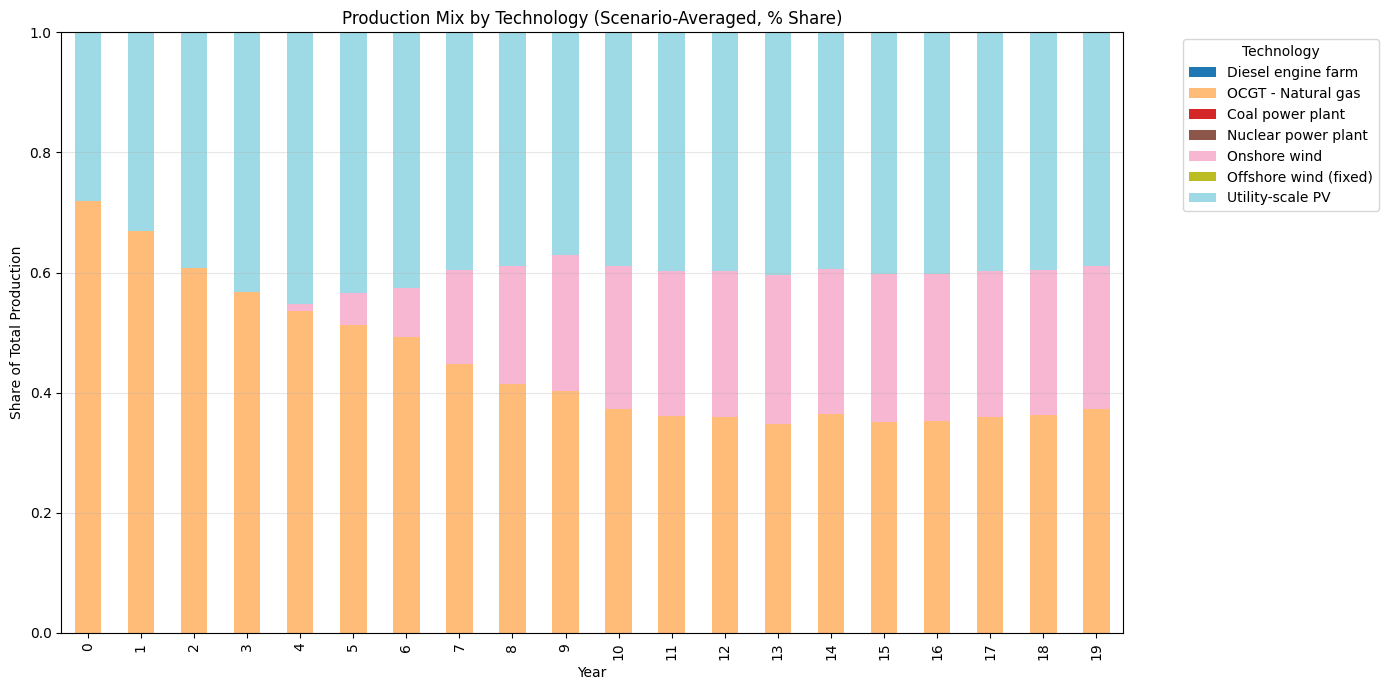

In [21]:
prod_share = {}

for t in time_periods:
    total_t = mean_total[t]
    prod_share[t] = {
        tech: expected_prod[tech][t] / total_t if total_t > 0 else 0
        for tech in tech_names
    }
    
# Build dataframe (years × technologies)
prod_share_df = pd.DataFrame(prod_share).T

# Ensure rows sum to 1 (just in case of rounding)
prod_share_df = prod_share_df.div(prod_share_df.sum(axis=1), axis=0)

# Plot: 100% stacked bar chart
plt.figure(figsize=(14,7))
prod_share_df.plot(
    kind="bar",
    stacked=True,
    figsize=(14,7),
    colormap="tab20"
)

plt.title("Production Mix by Technology (Scenario-Averaged, % Share)")
plt.xlabel("Year")
plt.ylabel("Share of Total Production")
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.legend(
    title="Technology",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()

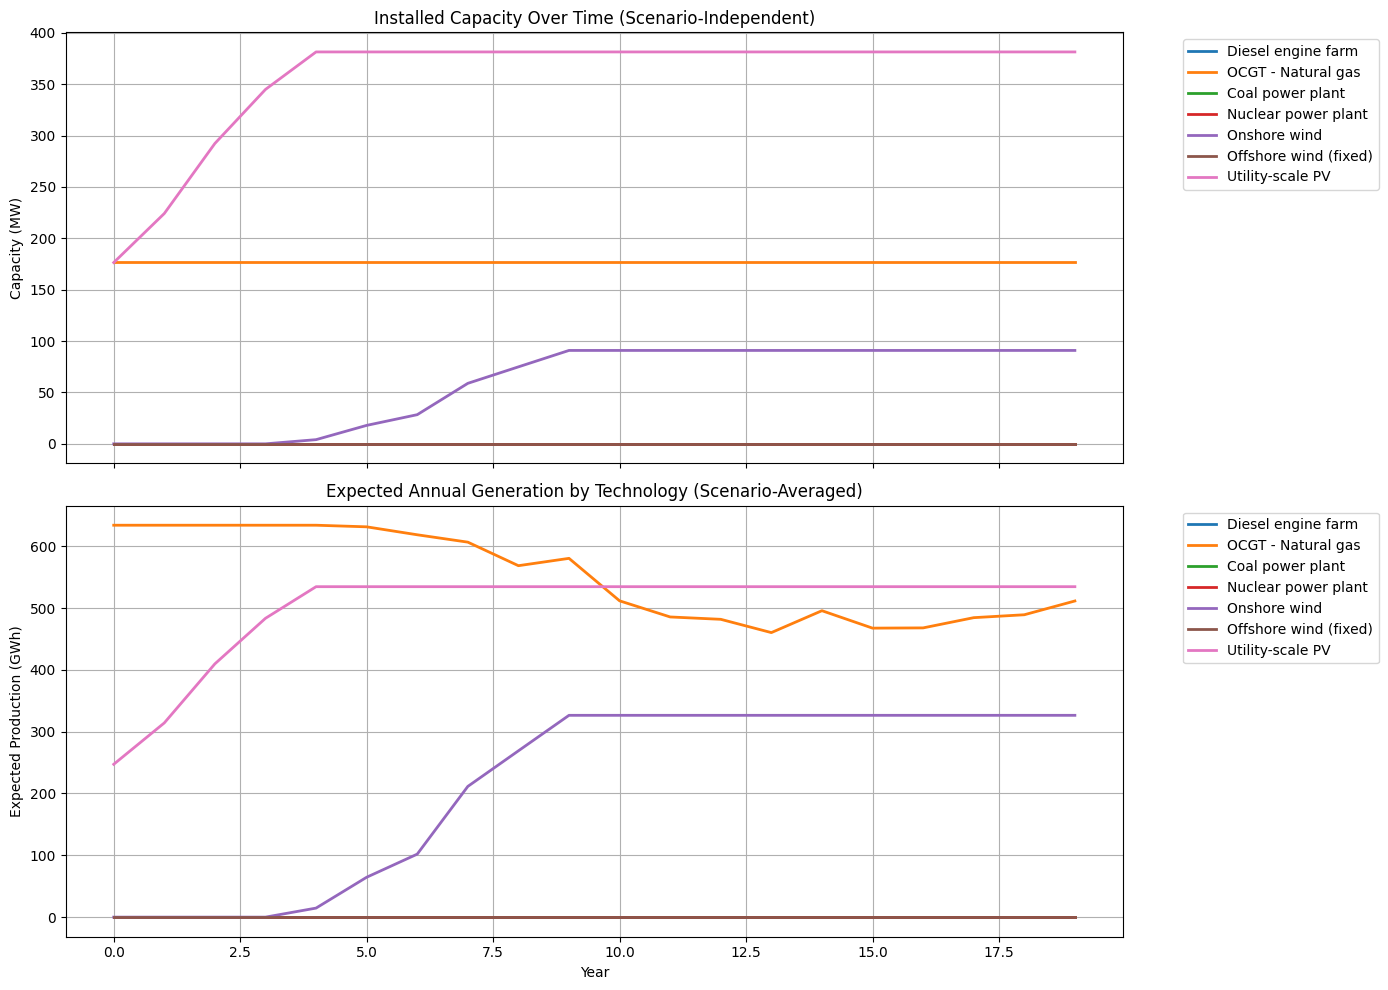

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare expected production per tech
expected_prod = {
    tech: [
        np.mean([energy[tech, t, s].X for s in scenarios])
        for t in time_periods
    ]
    for tech in tech_names
}

# Prepare capacity per tech
capacity_vals = {
    tech: [capacity[tech, t].X for t in time_periods]
    for tech in tech_names
}

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# 1) Top subplot — Installed Capacity over time
ax = axes[0]

for tech in tech_names:
    ax.plot(time_periods, capacity_vals[tech],
            label=tech, linewidth=2)

ax.set_ylabel("Capacity (MW)")
ax.set_title("Installed Capacity Over Time (Scenario-Independent)")
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")

# 2) Bottom subplot — Expected Production over time
ax = axes[1]

for tech in tech_names:
    ax.plot(time_periods, np.array(expected_prod[tech]) / 1e3,
            label=tech, linewidth=2)

ax.set_xlabel("Year")
ax.set_ylabel("Expected Production (GWh)")
ax.set_title("Expected Annual Generation by Technology (Scenario-Averaged)")
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")

# Layout
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

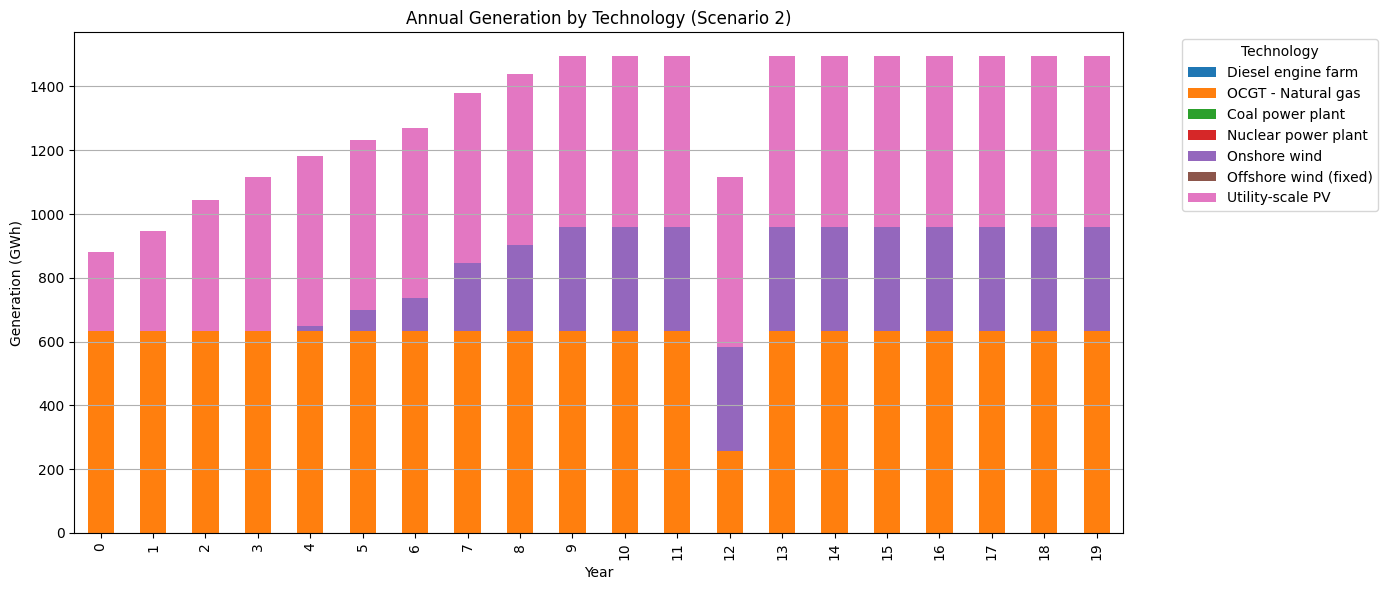

In [23]:
# Choose scenario
s = 2

# Build a DataFrame: rows = years, columns = technologies
prod_df = pd.DataFrame({
    tech: [energy[tech, t, s].X for t in time_periods]
    for tech in tech_names
}, index=time_periods)

# Convert MWh → GWh for readability (optional)
prod_df_gwh = prod_df / 1e3

plt.figure(figsize=(14, 7))
prod_df_gwh.plot(kind="bar", stacked=True, figsize=(14,6))

plt.title(f"Annual Generation by Technology (Scenario {s})")
plt.xlabel("Year")
plt.ylabel("Generation (GWh)")
plt.grid(True, axis='y')
plt.legend(title="Technology", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

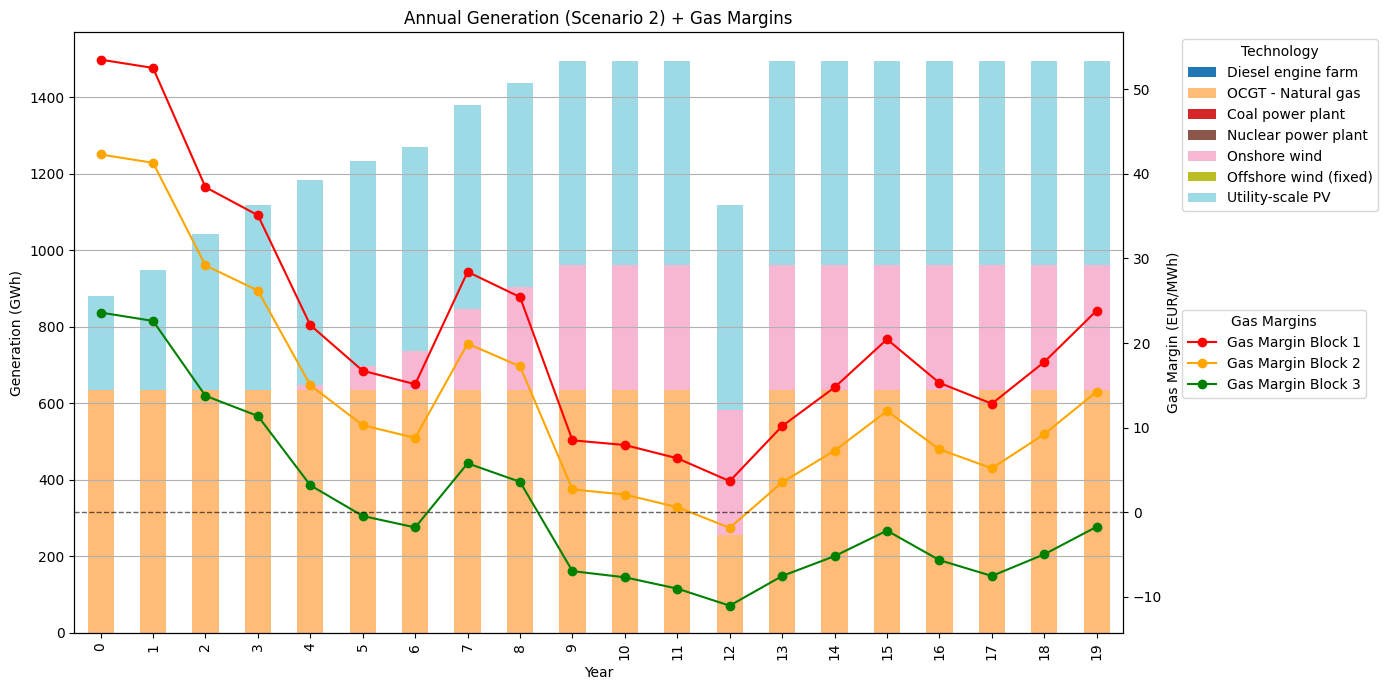

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Choose scenario ---
s = 2

# --- Build production dataframe ---
prod_df = pd.DataFrame({
    tech: [energy[tech, t, s].X for t in time_periods]
    for tech in tech_names
}, index=time_periods)

# Convert to GWh
prod_df_gwh = prod_df / 1e3

# --- Compute marginal prices for gas ---
tech = "OCGT - Natural gas"

marginal_price = {b: [] for b in blocks}

for t in time_periods:
    for b in blocks:
        # effective revenue (EUR/MWh)
        rev = (
            pi_block[(s, t, b)] * gamma[(tech, s, t)] * net_revenue_factor
        ) * 1e6
        
        # cost (EUR/MWh)
        cost = (
            vom_meur[tech] + 
            co2_intensity[tech] * carbon_price_meur_per_tco2[t]
        ) * 1e6
        
        marginal_price[b].append(rev - cost)  # margin in EUR/MWh

# --- PLOT ---
fig, ax1 = plt.subplots(figsize=(14, 7))

# LEFT AXIS → Production bars
prod_df_gwh.plot(kind="bar", stacked=True, ax=ax1, colormap="tab20")

ax1.set_title(f"Annual Generation (Scenario {s}) + Gas Margins")
ax1.set_xlabel("Year")
ax1.set_ylabel("Generation (GWh)")
ax1.grid(True, axis='y')

# RIGHT AXIS → Gas marginal prices
ax2 = ax1.twinx()
colors = ["red", "orange", "green"]

for i, b in enumerate(blocks):
    ax2.plot(time_periods, marginal_price[b], 
             marker="o", linestyle="-", 
             color=colors[i], label=f"Gas Margin Block {b}")

ax2.set_ylabel("Gas Margin (EUR/MWh)")
ax2.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.6)

# Legends
ax1.legend(title="Technology", bbox_to_anchor=(1.05, 1), loc="upper left")
ax2.legend(title="Gas Margins", bbox_to_anchor=(1.05, 0.55), loc="upper left")

plt.tight_layout()
plt.show()

Revenues

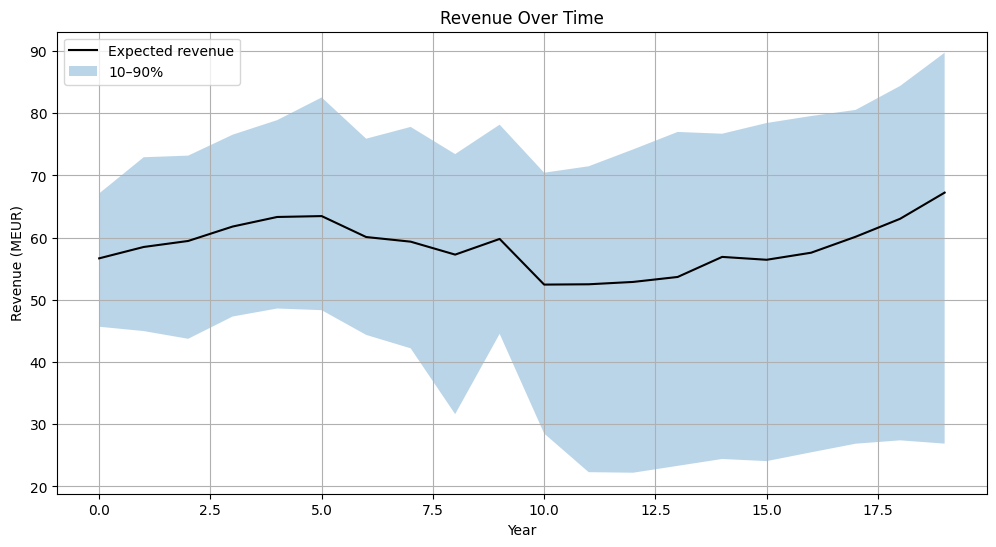

In [25]:
# Build revenue matrix (scenarios × years)
rev_mat = np.array([
    [revenue[t,s].X for t in time_periods]
    for s in scenarios
])

rev_mean = rev_mat.mean(axis=0)
rev_p10  = np.percentile(rev_mat, 10, axis=0)
rev_p90  = np.percentile(rev_mat, 90, axis=0)

# Table
df_rev_summary = pd.DataFrame({
    "Mean (MEUR)": rev_mean,
    "10th %": rev_p10,
    "90th %": rev_p90
})
df_rev_summary.index = time_periods

plt.figure(figsize=(12,6))
plt.plot(time_periods, rev_mean, label="Expected revenue", color="black")
plt.fill_between(time_periods, rev_p10, rev_p90, alpha=0.3, label="10–90%")
plt.grid(True)
plt.xlabel("Year")
plt.ylabel("Revenue (MEUR)")
plt.title("Revenue Over Time")
plt.legend()
plt.show()

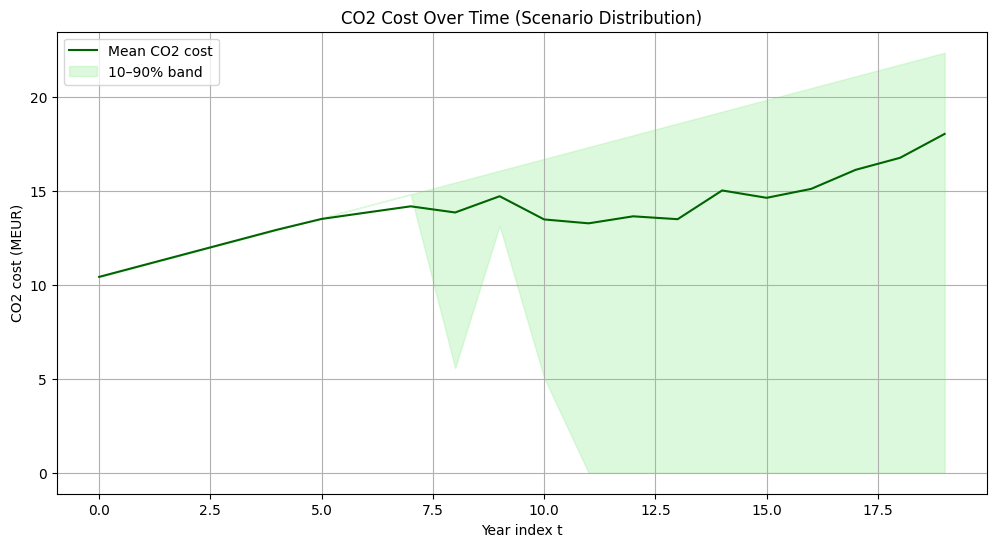

In [26]:
co2_mat = np.array([
    [co2_cost[t,s].X for t in time_periods]
    for s in scenarios
])

df_co2_summary = pd.DataFrame({
    "Mean CO2 cost": co2_mat.mean(axis=0),
    "10%": np.percentile(co2_mat, 10, axis=0),
    "90%": np.percentile(co2_mat, 90, axis=0)
}, index=time_periods)

df_co2_summary

plt.figure(figsize=(12,6))

x = df_co2_summary.index
mean_co2 = df_co2_summary["Mean CO2 cost"].values
p10_co2 = df_co2_summary["10%"].values
p90_co2 = df_co2_summary["90%"].values

plt.plot(x, mean_co2, label="Mean CO2 cost", color="darkgreen")
plt.fill_between(x, p10_co2, p90_co2, alpha=0.3, color="lightgreen", label="10–90% band")

plt.grid(True)
plt.xlabel("Year index t")
plt.ylabel("CO2 cost (MEUR)")
plt.title("CO2 Cost Over Time (Scenario Distribution)")
plt.legend()
plt.show()

Market Interaction and Competition

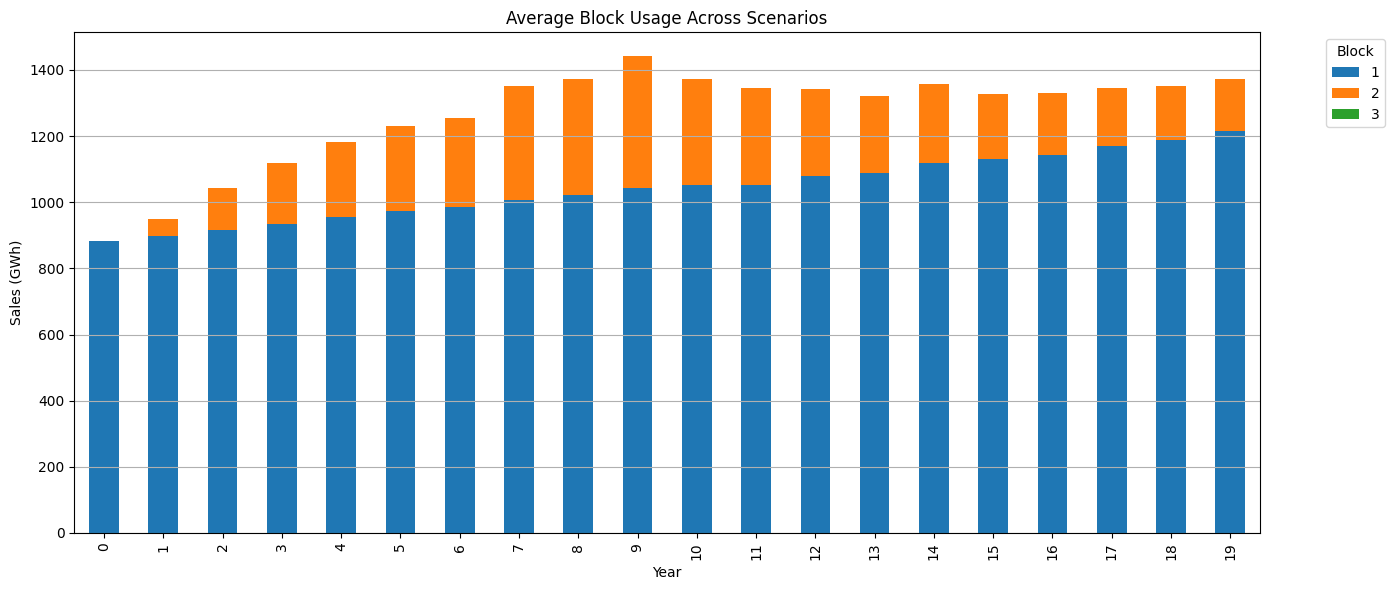

In [27]:
# Compute average block sales across all scenarios
block_avg = {
    b: [
        np.mean([sum(sales[tech, t, b, s].X for tech in tech_names)
                 for s in scenarios])
        for t in time_periods
    ]
    for b in blocks
}

block_df = pd.DataFrame(block_avg, index=time_periods) / 1e3  # GWh

block_df.plot(kind="bar", stacked=True, figsize=(14,6))
plt.title("Average Block Usage Across Scenarios")
plt.xlabel("Year")
plt.ylabel("Sales (GWh)")
plt.legend(title="Block", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

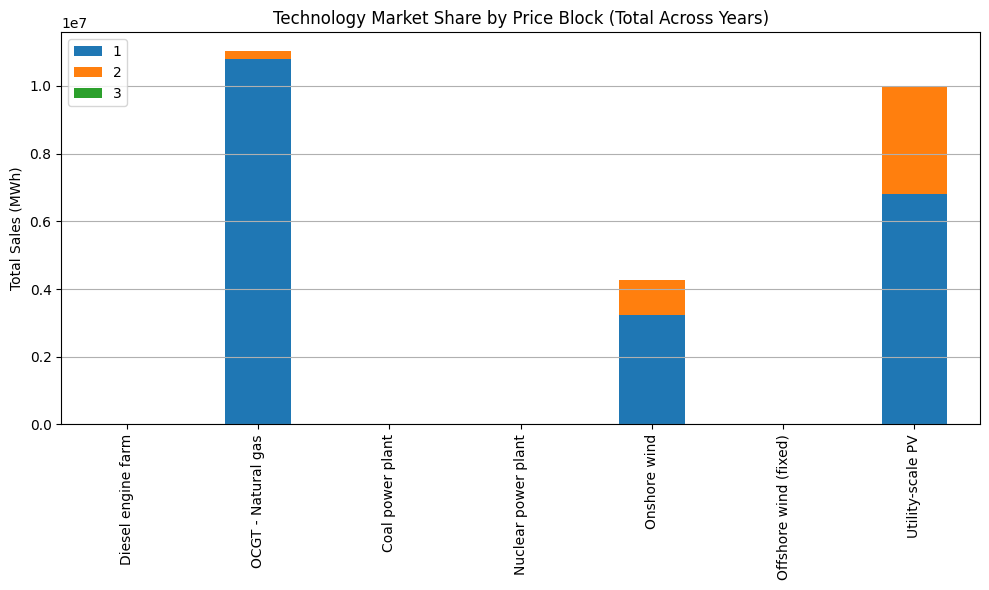

In [28]:
block_share = {}

for b in blocks:
    block_share[b] = {
        tech: np.mean([
            sum(sales[tech, t, b, s].X for t in time_periods)
            for s in scenarios
        ])
        for tech in tech_names
    }

df_blockshare = pd.DataFrame(block_share)
df_blockshare.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Technology Market Share by Price Block (Total Across Years)")
plt.ylabel("Total Sales (MWh)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [29]:
records = []

for tech in tech_names:
    for s in scenarios:
        for t in time_periods:
            for b in blocks:
                price_eff = (
                    pi_block[(s,t,b)] 
                    * gamma[(tech, s, t)]
                    * net_revenue_factor
                ) * 1e6  # convert MEUR/MWh → EUR/MWh

                records.append({
                    "Technology": tech,
                    "Scenario": s,
                    "Year": t,
                    "Block": b,
                    "EffPrice_EUR_MWh": price_eff
                })

df_eff = pd.DataFrame(records)

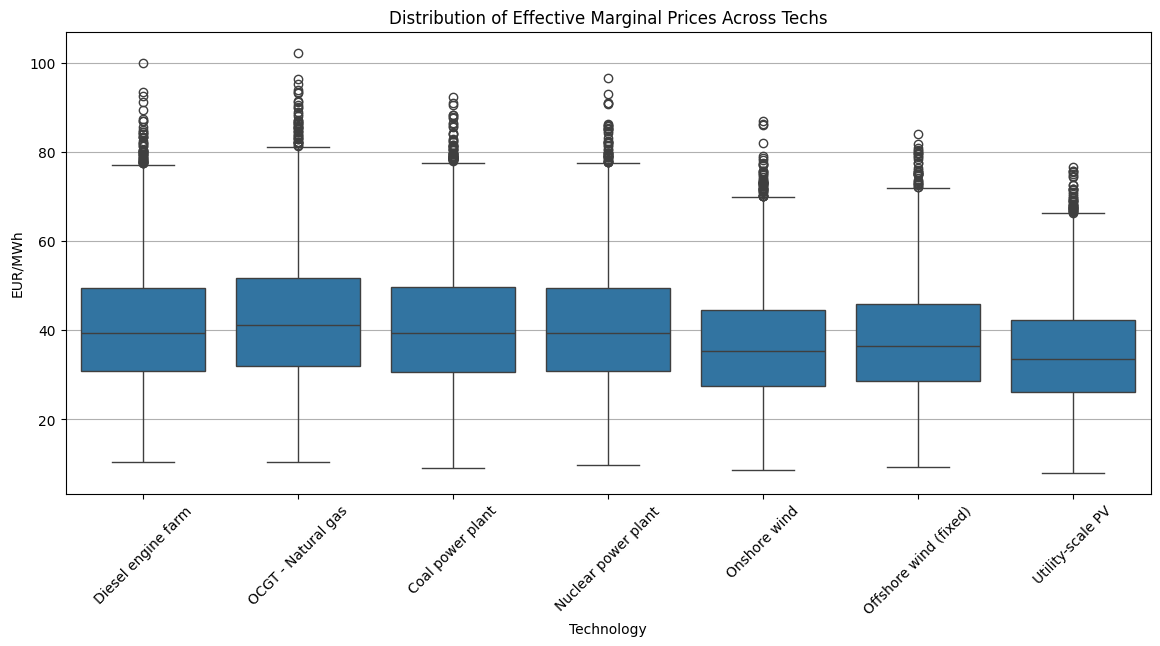

In [30]:
import seaborn as sns

plt.figure(figsize=(14,6))
sns.boxplot(data=df_eff, x="Technology", y="EffPrice_EUR_MWh")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.title("Distribution of Effective Marginal Prices Across Techs")
plt.ylabel("EUR/MWh")
plt.show()

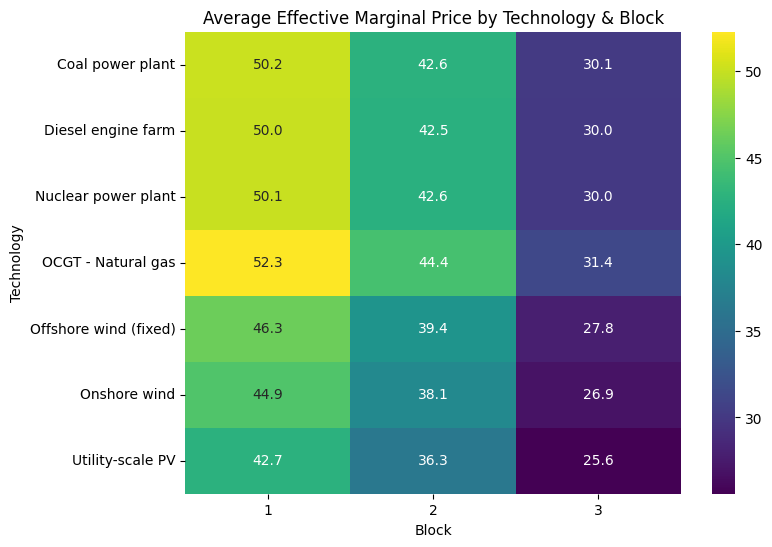

In [31]:
pivot = df_eff.groupby(["Technology","Block"])["EffPrice_EUR_MWh"].mean().unstack()

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis")
plt.title("Average Effective Marginal Price by Technology & Block")
plt.ylabel("Technology")
plt.xlabel("Block")
plt.show()

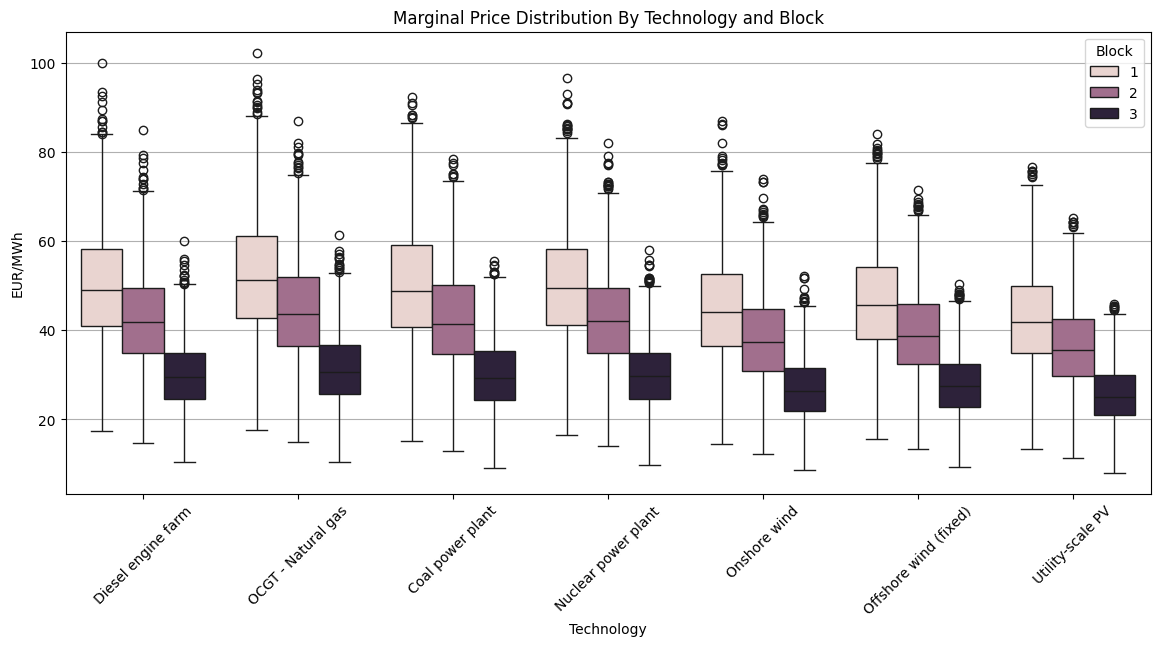

In [32]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_eff, x="Technology", y="EffPrice_EUR_MWh", hue="Block")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.title("Marginal Price Distribution By Technology and Block")
plt.ylabel("EUR/MWh")
plt.legend(title="Block")
plt.show()

Financial Performance & Unit Economics

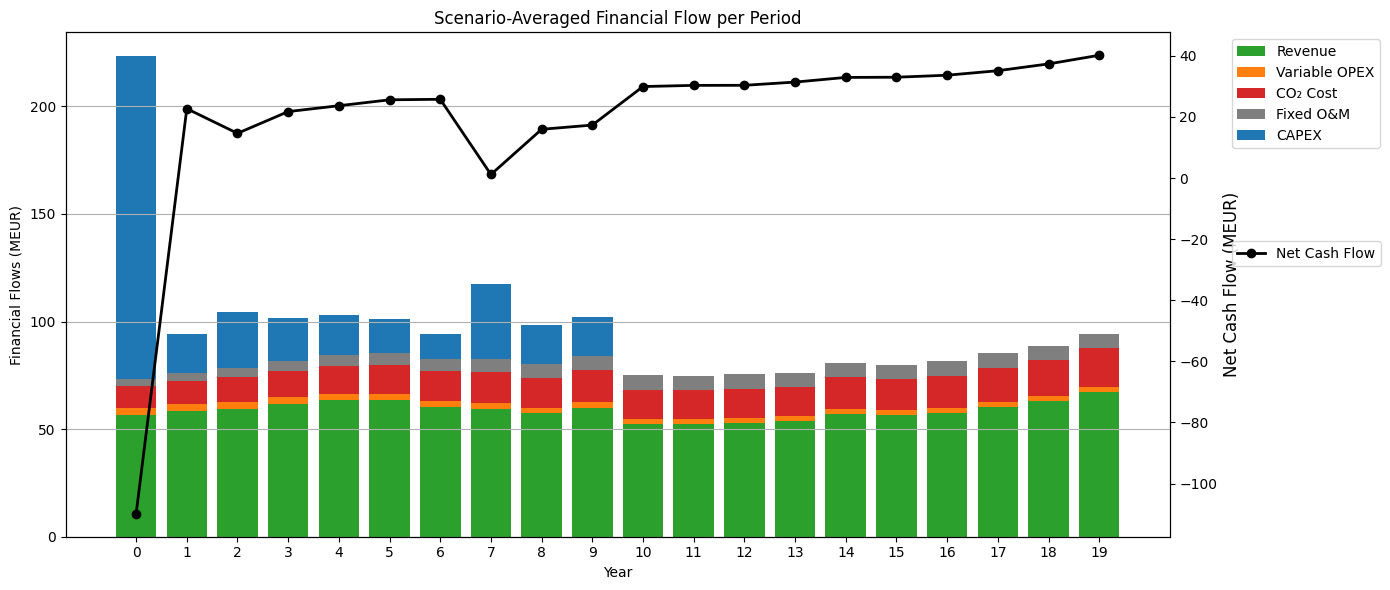

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Compute scenario averages ----
rev = np.array([
    np.mean([revenue[t, s].X for s in scenarios])
    for t in time_periods
])

op = np.array([
    np.mean([op_cost[t, s].X for s in scenarios])
    for t in time_periods
])

co2 = np.array([
    np.mean([co2_cost[t, s].X for s in scenarios])
    for t in time_periods
])

fix = np.array([fixed_om_cost[t].X for t in time_periods])      # scenario independent
cap = np.array([capex_cost[t].X for t in time_periods])         # scenario independent

# ---- Net cash flow (revenue minus all costs) ----
net_cash = rev - (op + co2 + fix + cap)

x = np.arange(len(time_periods))

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(14,6))

# ---- Stacked bars for financial components ----
ax1.bar(x, rev, label="Revenue", color="tab:green")

ax1.bar(x, op, 
        bottom=rev, label="Variable OPEX", color="tab:orange")

ax1.bar(x, co2, 
        bottom=rev+op, label="CO₂ Cost", color="tab:red")

ax1.bar(x, fix, 
        bottom=rev+op+co2, label="Fixed O&M", color="tab:gray")

ax1.bar(x, cap, 
        bottom=rev+op+co2+fix, label="CAPEX", color="tab:blue")

ax1.set_xlabel("Year")
ax1.set_ylabel("Financial Flows (MEUR)")
ax1.set_title("Scenario-Averaged Financial Flow per Period")
ax1.set_xticks(x)
ax1.set_xticklabels(time_periods)
ax1.grid(True, axis='y')

# ---- Second Y-axis for Net Cash Flow ----
ax2 = ax1.twinx()
ax2.plot(x, net_cash, marker="o", linestyle="-", 
         color="black", linewidth=2, label="Net Cash Flow")

ax2.set_ylabel("Net Cash Flow (MEUR)", fontsize=12)

# ---- Legends ----
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.05, 0.6), loc="upper left")

plt.tight_layout()
plt.show()

Inspecting Duals

In [34]:
# ---- Extract duals: Block capacity constraints ----
dual_block = []

for t in time_periods:
    for b in blocks:
        for s in scenarios:
            cname = f"BlockCap_{t}_{b}_s{s}"
            c = model.getConstrByName(cname)
            if c is not None:
                dual_block.append({
                    "Year": t,
                    "Block": b,
                    "Scenario": s,
                    "Dual": c.Pi
                })

df_dual_block = pd.DataFrame(dual_block)


# ---- Extract duals: Max capacity constraints ----
dual_cap = []

for tech in tech_names:
    for t in time_periods:
        cname = f"MaxCap_{tech}_{t}"
        c = model.getConstrByName(cname)
        if c is not None:
            dual_cap.append({
                "Technology": tech,
                "Year": t,
                "Dual": c.Pi
            })

df_dual_cap = pd.DataFrame(dual_cap)

# ---- Extract duals: Budget recursion constraints ----
dual_budget = []

for t in time_periods[:-1]:
    for s in scenarios:
        cname = f"BudgetDyn_{t}_s{s}"
        c = model.getConstrByName(cname)
        if c is not None:
            dual_budget.append({
                "Year": t,
                "Scenario": s,
                "Dual": c.Pi
            })

df_dual_budget = pd.DataFrame(dual_budget)

<Figure size 1200x600 with 0 Axes>

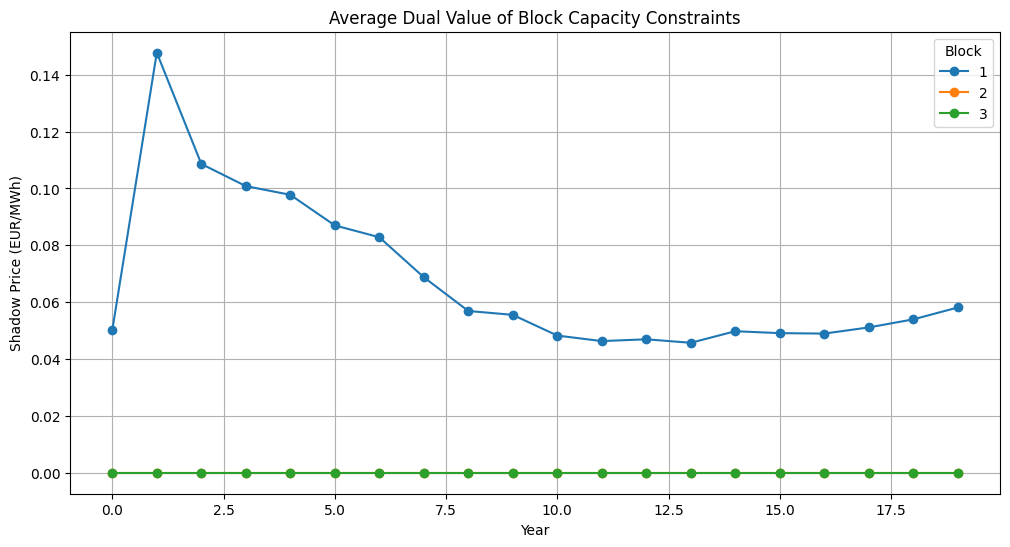

In [35]:
plt.figure(figsize=(12,6))

df_plot = df_dual_block.groupby(["Year","Block"])["Dual"].mean().unstack() *1e6  # EUR/MWh

df_plot.plot(kind="line", marker="o", figsize=(12,6))
plt.title("Average Dual Value of Block Capacity Constraints")
plt.ylabel("Shadow Price (EUR/MWh)")
plt.xlabel("Year")
plt.grid(True)
plt.legend(title="Block")
plt.show()

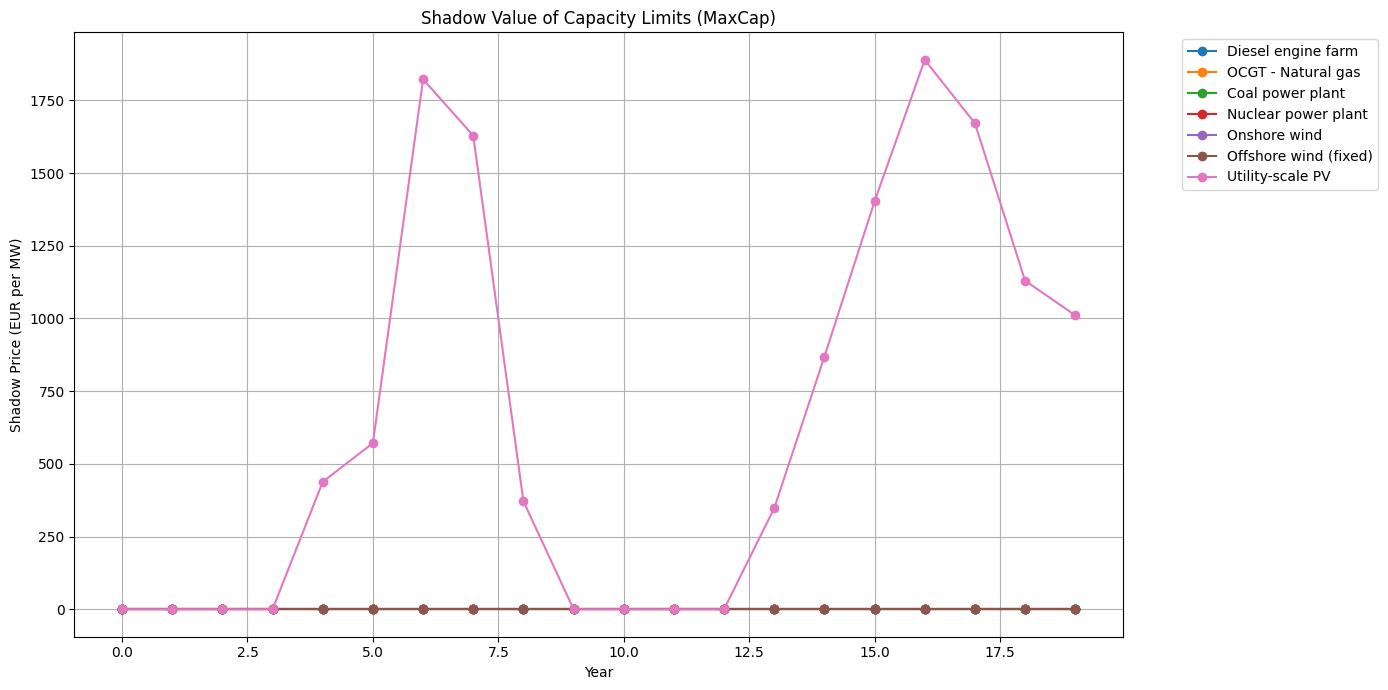

In [36]:
plt.figure(figsize=(14,7))

for tech in tech_names:
    vals = df_dual_cap[df_dual_cap["Technology"] == tech]["Dual"].values
    plt.plot(time_periods, vals*1e6, marker="o", label=tech)

plt.title("Shadow Value of Capacity Limits (MaxCap)")
plt.xlabel("Year")
plt.ylabel("Shadow Price (EUR per MW)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

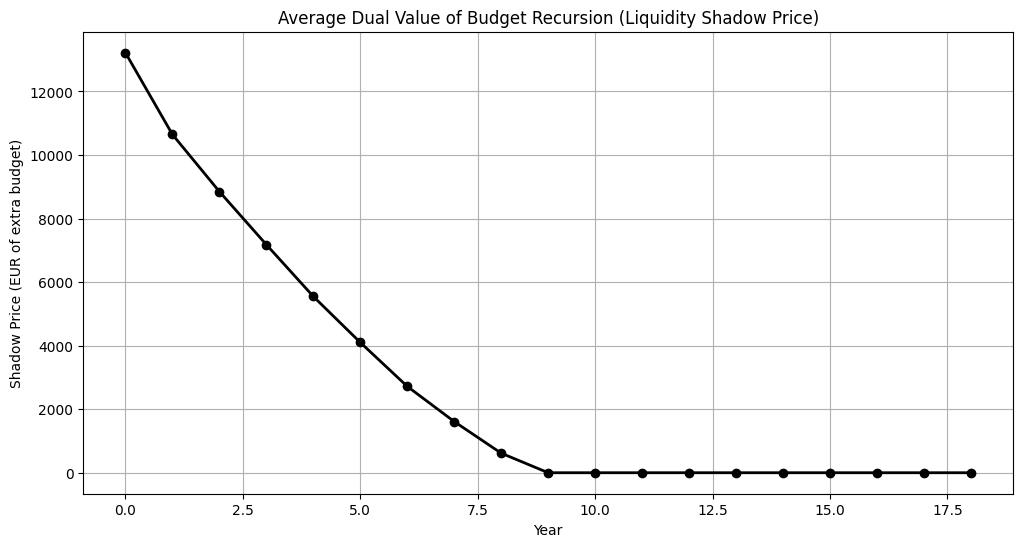

In [37]:
plt.figure(figsize=(12,6))

budget_mean = df_dual_budget.groupby("Year")["Dual"].mean()

plt.plot(budget_mean.index, budget_mean.values * 1e6,
         marker="o", linewidth=2, color="black")

plt.title("Average Dual Value of Budget Recursion (Liquidity Shadow Price)")
plt.xlabel("Year")
plt.ylabel("Shadow Price (EUR of extra budget)")
plt.grid(True)
plt.show()